### 取得股票基本資料

In [1]:
import talib
import numpy as np
import pandas as pd

folder = '/Volumes/Macintosh HD/history/items/price'

columns = ['Open', 'High', 'Low', 'Close', 'Volume']
files = ['開盤價', '最高價', '最低價' ,'收盤價', '成交筆數']

stock_id = '2412'

df = pd.DataFrame()

for idx, filename in enumerate(files):
    df_temp = pd.read_pickle(f"{folder}/{filename}.pkl")
    s = df_temp[stock_id]
    df[columns[idx]] = s
    df[columns[idx]].fillna(method='ffill', inplace=True)

df['Name'] = stock_id

### ADLine - 進貨/出貨線 (Accumulation/Distribution Line)
```ADLine = ((收盤價-最低價)-(最高價-收盤價)) / (最高價 - 最低價) * 成交量```

In [2]:
df_false = df['High'] - df['Low'] != 0
df.loc[df_false, 'ad'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] ) * df['Volume']

df_true = df['High'] - df['Low'] == 0
df.loc[df_true,'ad']= df['Close'] / df.shift(1)['Close'] - 1

In [3]:
AD = talib.AD(df['High'],df['Low'], df['Close'], df['Volume'])

df['talib-ad'] = AD

### ADOSC - 蔡金擺動指標 (Chaikin A/D Oscillator)

In [4]:
adosc = talib.ADOSC(df['High'],df['Low'], df['Close'], df['Volume'], fastperiod=3, slowperiod=10)

df['talib-adosc'] = adosc

### ADX - 平均趨向指數（Average Directional Movement Index)


ADX 須配合 +DI & -DI 一起判斷

In [5]:
adx_period = 14

ADX = talib.ADX(df['High'], df['Low'], df['Close'], adx_period)
df['talib-adx'] = ADX

In [6]:
# TR

df_adx = df[['High','Low','Close']].copy()

tr_1 = abs(df_adx['High'] - df_adx['Close'].shift(1))
tr_2 = abs(df_adx['Close'].shift(1) - df_adx['Low'])
tr_3 = abs(df_adx['High'] - df_adx['Low'])

tr_period = f'tr{adx_period}'

temp = pd.DataFrame( { 'tr1': tr_1, 'tr2': tr_2 , 'tr3': tr_3 }) 
df_adx['tr'] = temp.max(axis=1)
df_adx[tr_period] = df_adx['tr'].rolling(adx_period).mean().shift(1-adx_period)
df_adx[tr_period] = df_adx[tr_period].fillna(value=0)

for i, (index, row) in enumerate(df_adx.iterrows()):
    if i == 0:
        continue
    row[tr_period] = (df_adx.iloc[i-1][tr_period] * (adx_period - 1) / adx_period) + row.tr * 1 / adx_period

In [7]:
# DM
df_adx['dm_positive'] = df_adx['High'] - df_adx['High'].shift(1)
df_adx['dm_negative'] = df_adx['Low'].shift(1) - df_adx['Low']

def dm_apply(row):
    # 若+DM>-DM成立，且+DM大於0
    if row['dm_positive'] < 0 or row['dm_positive'] <= row['dm_negative']:
        row['dm_positive'] = 0
    # 若+DM<-DM成立，且-DM大於0
    if row['dm_negative'] < 0 or row['dm_negative'] <= row['dm_positive']:
        row['dm_negative'] = 0
        
    return row
    
df_adx = df_adx.apply(dm_apply, axis=1)

# DM(14)
dmp_period = f'dm_positive{adx_period}'
dmn_period = f'dm_negative{adx_period}'

df_adx[dmp_period] = df_adx['dm_positive'].rolling(adx_period).mean().shift(1-adx_period)
df_adx[dmn_period] = df_adx['dm_negative'].rolling(adx_period).mean().shift(1-adx_period)
df_adx[[dmp_period, dmn_period]] = df_adx[[dmp_period,dmn_period]].fillna(value=0)

for i, (index, row) in enumerate(df_adx.iterrows()):
    if i == 0:
        continue
    
    row[dmp_period] = \
        (df_adx.iloc[i-1][dmp_period] * (adx_period - 1) / adx_period) + row.dm_positive * 1 / adx_period
    row[dmn_period] = \
        (df_adx.iloc[i-1][dmn_period] * (adx_period - 1) / adx_period) + row.dm_negative * 1 / adx_period

In [157]:
# DI
dip_period = f'di_positive{adx_period}'
din_period = f'di_negative{adx_period}'
df_adx[dip_period] = df_adx[dmp_period] / df_adx[tr_period] * 100
df_adx[din_period] = df_adx[dmn_period] / df_adx[tr_period] * 100

# DX
df_adx['dx'] = abs(df_adx[dip_period] - df_adx[din_period]) \
                / (df_adx[dip_period] + df_adx[din_period]) \
                * 100

df_adx['dx'] = df_adx['dx'].fillna(0)

# ADX
df_adx['adx'] = df_adx['dx'].rolling(adx_period).mean().shift(1-adx_period)
df_adx['adx'] = df_adx['adx'].fillna(value=0)

for i, (index, row) in enumerate(df_adx.iterrows()):
    if i == 0:
        continue
    
    row.adx = (df_adx.iloc[i-1]['adx'] * (adx_period - 1) / adx_period) + row.dx * 1 / adx_period + 0.00000000001

df[dip_period] = df_adx[dip_period]
df[din_period] = df_adx[din_period]
df['adx'] = df_adx['adx']

### ADXR - 平均方向指數評估 (Average Directional Movement Index Rating)

In [9]:
df['adxr'] = (df['adx'] + df['adx'].shift(adx_period - 1)) / 2
df['talib-adxr'] = talib.ADXR(df['High'], df['Low'], df['Close'], timeperiod=14)

### APO - 絕對價格震盪指標(Absolute Price Oscillator)

In [10]:
df_apo = df[['Close']].copy()

df_apo['talib-ma26'] = talib.MA(df['Close'], timeperiod=26)
df_apo['talib-ma12'] = talib.MA(df['Close'], timeperiod=12)

df['talib-apo'] = talib.APO(df['Close'], fastperiod=12, slowperiod=26)

df['apo'] = abs(df_apo['talib-ma26'] - df_apo['talib-ma12'])

### AROON - 阿隆指標

In [168]:
(aroondown, aroonup) = talib.AROON(df['High'], df['Low'], adx_period)

df['talib-aroon-up'] = aroonup
df['talib-aroon-down'] = aroondown

# df.loc[df['High'].rolling(adx_period).apply(lambda x: x.argmax())]

df_aroon = df['High'].rolling(adx_period).apply(lambda x: x[[x.argmax()]]).head(40)

date
2007-04-23     NaN
2007-04-24     NaN
2007-04-25     NaN
2007-04-26     NaN
2007-04-27     NaN
2007-04-30     NaN
2007-05-02     NaN
2007-05-03     NaN
2007-05-04     NaN
2007-05-07     NaN
2007-05-08     NaN
2007-05-09     NaN
2007-05-10     NaN
2007-05-11    65.3
2007-05-14    64.9
2007-05-15    64.5
2007-05-16    64.0
2007-05-17    64.0
2007-05-18    64.0
2007-05-21    64.0
2007-05-22    64.0
2007-05-23    64.0
2007-05-24    64.0
2007-05-25    64.0
2007-05-28    64.0
2007-05-29    64.0
2007-05-30    64.0
2007-05-31    64.0
2007-06-01    64.0
2007-06-04    64.0
2007-06-05    64.0
2007-06-06    63.6
2007-06-07    63.4
2007-06-08    63.4
2007-06-11    63.4
2007-06-12    63.1
2007-06-13    63.1
2007-06-14    63.1
2007-06-15    63.0
2007-06-20    63.0
Name: High, dtype: float64

### AROONOSC - 阿隆震盪 (AROON Oscillator)

### CCI - 商品通道指標 (Commodity Channel Index)

In [12]:
df_cci = df[['High', 'Low', 'Close']].copy()
df_cci['tp'] = (df_cci['High'] + df_cci['Low'] + df_cci['Close']) / 3

df_cci['ma'] = df_cci['tp'].rolling(window=adx_period, min_periods=1).mean()

df_cci['md'] = abs(df_cci['ma'] - df_cci['tp'])
df_cci['md'] = df_cci['md'].rolling(window=adx_period, min_periods=1).mean()

df_cci['cci'] = (df_cci['tp'] - df_cci['ma']) / 0.015 / df_cci['md']

df_cci['talib-cci'] = talib.CCI(high=df_cci['High'], 
                                low=df_cci['Low'], 
                                close=df_cci['Close'], 
                                timeperiod=adx_period)
df_cci.head(30)

,High,Low,Close,tp,ma,md,cci,talib-cci
date,,,,,,,,
2007-04-23,65.3,64.4,64.6,64.766667,64.766667,0.000000,NaN,NaN
2007-04-24,64.9,64.0,64.6,64.500000,64.633333,0.066667,-133.333333,NaN
2007-04-25,64.5,63.7,63.8,64.000000,64.422222,0.185185,-152.000000,NaN
2007-04-26,64.0,63.1,63.1,63.400000,64.166667,0.330556,-154.621849,NaN
2007-04-27,63.8,63.1,63.3,63.400000,64.013333,0.387111,-105.625718,NaN
2007-04-30,63.5,62.6,63.1,63.066667,63.855556,0.454074,-115.823817,NaN
2007-05-02,63.3,62.6,62.9,62.933333,63.723810,0.502132,-104.949422,NaN
2007-05-03,63.6,63.1,63.3,63.333333,63.675000,0.482073,-47.249604,NaN
2007-05-04,63.8,63.2,63.3,63.433333,63.648148,0.452378,-31.657126,NaN


### CMO - 錢德動量擺動指標 (Chande Momentum Oscillator)

In [13]:
zeros = pd.Series(0, index=df.index)

df_cmo = pd.DataFrame({ 'su': df['Close'] - df['Close'].shift(1), 
                        'sd': df['Close'].shift(1) - df['Close'],
                        'zero': pd.Series(0, index=df.index) })

df_cmo['su'] = df_cmo[['su','zero']].max(axis=1)
df_cmo['sd'] = df_cmo[['sd','zero']].max(axis=1)

df_cmo['su_sum'] = df_cmo['su'].rolling(adx_period).sum()
df_cmo['sd_sum'] = df_cmo['sd'].rolling(adx_period).sum()

df['cmo'] = (df_cmo['su_sum'] - df_cmo['sd_sum']) / (df_cmo['su_sum'] + df_cmo['sd_sum']) * 100
df['talib-cmo'] = talib.CMO(df['Close'], timeperiod=14)

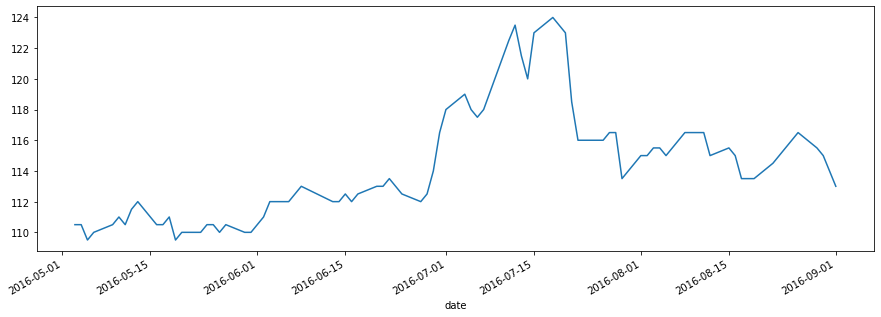

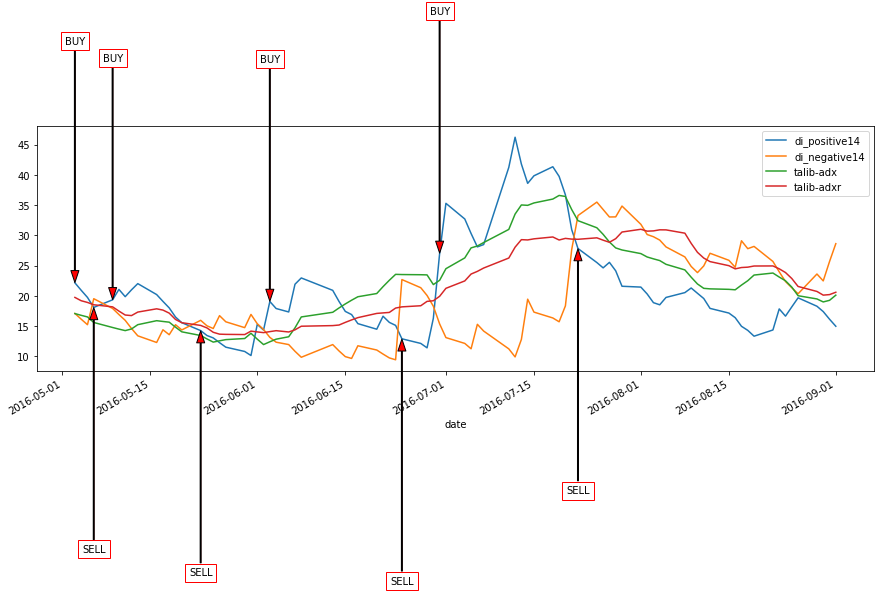

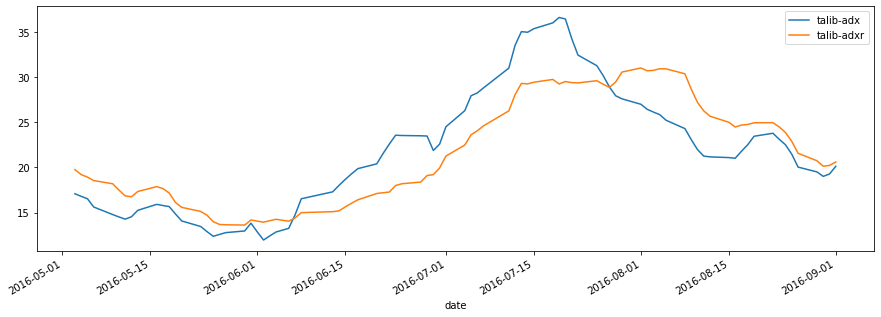

In [161]:
start='2016-05-01'
end='2016-09-01'

ax1 = df['Close'].loc[start:end].plot(figsize=(15,5))
ax3 = df[['talib-adx', 'talib-adxr']].loc[start:end].plot(figsize=(15,5))
ax2 = df[['di_positive14', 'di_negative14', 'talib-adx', 'talib-adxr']].loc[start:end].plot(figsize=(15,5))

up_point = (df['di_positive14'] >= df['di_negative14']) & \
            (df['di_positive14'].shift(1) <= df['di_negative14'].shift(1))

down_point = (df['di_negative14'] >= df['di_positive14']) & \
            (df['di_negative14'].shift(1) <= df['di_positive14'].shift(1))

def label_point(df_plot, val, ax, position):
    
    for i, point in df_plot.iterrows():
        ax.annotate(val, (i, point['di_positive14']), 
                    ha='center', va='center',
                    xytext=(i, point['di_positive14'] + position), 
                    bbox=dict(facecolor='none', edgecolor='red'), 
                    arrowprops=dict(facecolor='red', shrink=0.001, headwidth=8,width=1))

label_point(df[down_point].loc[start:end], 'SELL', ax2, -40)
label_point(df[up_point].loc[start:end], 'BUY', ax2, +40)

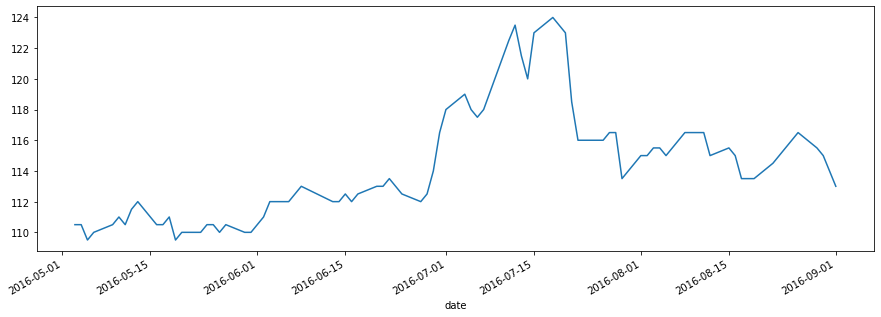

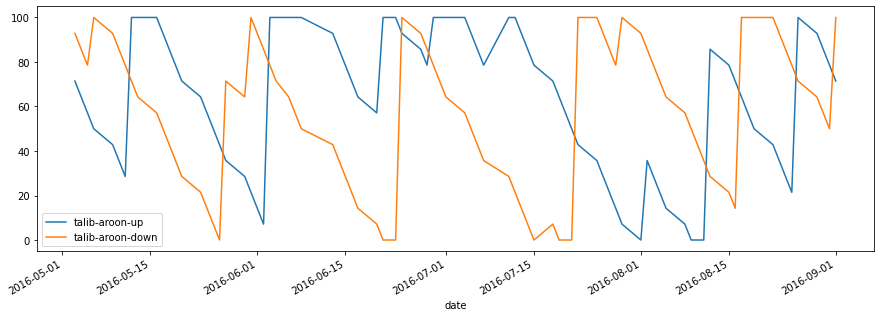

In [167]:
start='2016-05-01'
end='2016-09-01'

df['Close'].loc[start:end].plot(figsize=(15,5))
df[['talib-aroon-up','talib-aroon-down']].loc[start:end].plot(figsize=(15,5))